Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Description of readout:
- **HLM_CLEARANCE**: Intrinsic clearance measured in human liver microsomes following incubation at 37C. Experimental range <3 to >150 microL/min/mg. Rapid Commun. Mass Spectrom. 2010, 24, 1730-1736.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301370/

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

# For downloading ChEMBL datasets
from chembl_webresource_client.new_client import new_client as client
from tqdm.auto import tqdm
import warnings
import pandas as pd

We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [2]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [3]:
# load data
data = pd.read_parquet('gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301370_raw.parquet')
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14758721,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1,None,None,14758722,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
2,None,None,14758723,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
3,None,None,14758725,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
4,None,None,14758726,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,None,None,14769885,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1098,None,None,14769886,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1099,None,None,14769887,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0
1100,None,None,14769888,[],CHEMBL3301370,ASTRAZENECA: Intrinsic clearance measured in h...,A,None,None,BAO_0002759,...,None,ADMET,None,None,None,CLint,microL/min/mg,None,None,3.0


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "HLM_CLEARANCE",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,HLM_CLEARANCE
0,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O,3.0
1,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,3.0
2,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,3.0
3,Cc1cc(C)nc(SCC(N)=O)n1,3.0
4,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1,3.0
...,...,...
1097,O=C(NCCc1ccccc1)c1cc(-n2ncc(=O)[nH]c2=O)ccc1Cl,3.0
1098,C[C@H](CO)n1ccc2c(NC(=O)Cc3ccc(Cl)c(C(F)(F)F)c...,3.0
1099,Cc1nocc1C(=O)Nc1ccc(-c2ccccc2OC(F)(F)F)c(N)n1,3.0
1100,CCCCc1nc2c(N)nc3ccccc3c2n1CC(C)C,3.0


In [5]:
# Define data column names
endpoints = [
    'HLM_CLEARANCE',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [6]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curation detected no outliers in the data. Let's take a look at the distribution regardless.

In [7]:
data_look.head()

,SMILES,HLM_CLEARANCE,ORIGINAL_HLM_CLEARANCE,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_HLM_CLEARANCE,HLM_CLEARANCE_zscore,HLM_CLEARANCE_stereo_cliff
0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,63.00,63.00,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,3.482617,NaN
1,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,66.00,66.00,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,005d8e75a16c8416c45e430fc967a1a1952a5c4d,78c1d47af1df93c216b82a35bf23ac6ce4f58ff3,1,0,1,2,1,False,False,False,3.690473,NaN
2,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,21.88,21.88,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,00972dbe76634f2d504f676fa7642cd97bba466c,b009b3e23cb658c0f5b8d79ba1e62f0b42429a66,1,0,1,2,1,False,False,False,0.633613,NaN
3,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,36.00,36.00,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,00981ee1bdf3539824d157bc1c7dacf2f10c1bc1,29ecc51c5635b0a0bb33f9ec2103d93f6f3b39e8,0,0,0,1,1,False,True,False,1.611919,NaN
4,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,3.00,3.00,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,00bce5a1c5852386e632e642c04f8ceaa1a2d799,88d902c9ce575e5293b2cac2153d49a8cb3f14f5,0,0,0,1,1,False,True,False,-0.674491,NaN


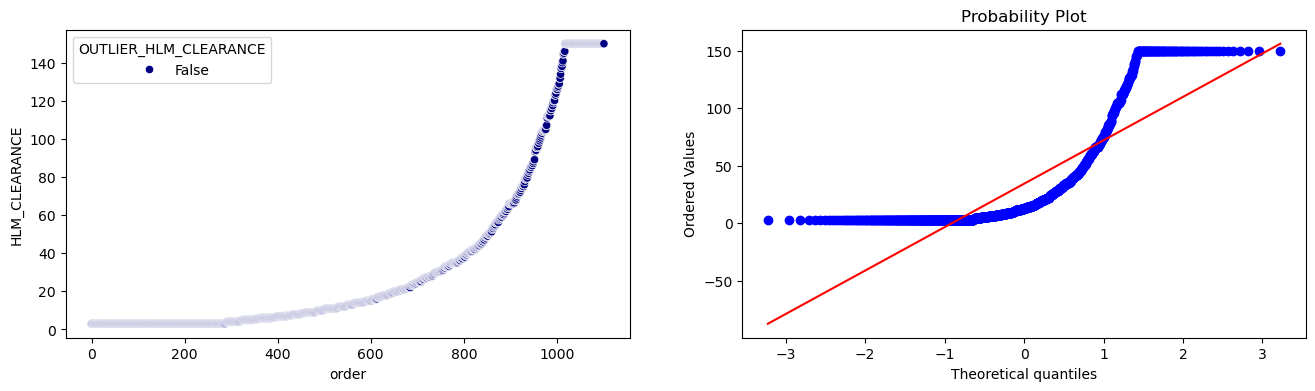

In [8]:
visualize_distribution(dataset=data_look, data_cols=data_cols);

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [9]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

HLM_CLEARANCE_stereo_cliff    4
dtype: object

Four activity shifts were detected in the dataset. Let's identify them for later removal.

In [10]:
data_look[~data_look["HLM_CLEARANCE_stereo_cliff"].isna()]

,SMILES,HLM_CLEARANCE,ORIGINAL_HLM_CLEARANCE,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_HLM_CLEARANCE,HLM_CLEARANCE_zscore,HLM_CLEARANCE_stereo_cliff
24,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,18.5,18.5,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,07767f6e75bf2a7e99f8df3c74158b9a294df80a,aeb3a903f8bf067d1ad19df16ff9289810e97a74,1,1,0,2,2,True,False,False,0.399429,True
137,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CC[C@@H](...,4.0,4.0,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CC[C@@H](...,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CC[C@@H](...,1e9ad39aca2924ac2fa22c7e49ed074e5d86c8b4,aeb3a903f8bf067d1ad19df16ff9289810e97a74,1,0,1,2,1,False,False,False,-0.605206,True
756,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,40.5,40.5,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,b1c2e28eb3d95c08fe0d36c8592bb93846e960ba,beb0319b6586636f70695b56deb15955d99a4d74,1,0,1,2,1,False,False,False,1.923702,True
904,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,58.5,58.5,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(...,d2afc3c1baa6e15b039834d9365cf497e1c53eab,beb0319b6586636f70695b56deb15955d99a4d74,1,0,1,2,1,False,False,False,3.170834,True


### Check the molecules with undefined stereocenters

Note: feature currently not working

In [11]:
# data_look['mol'] = data_look['smiles'].apply(dm.to_mol) # Convert smiles to RDKit Mol object
# fig, _ = check_undefined_stereocenters(dataset=data_look)
# fig

In [12]:
# _[data_cols].boxplot(rot=90)

### Re-run curation, removing molecules as needed

In [13]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f'size before curation: {len(data)}')
data_curated = curator_with_stereo()
print(f'size after curation: {len(data_curated)}')

size before curation: 1102
size after curation: 1102


/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Drop molecules with stereo activity cliff
data_curated = data_curated.drop(data_curated[~data_curated["HLM_CLEARANCE_stereo_cliff"].isna()].index)
data_curated

,SMILES,HLM_CLEARANCE,ORIGINAL_HLM_CLEARANCE,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_HLM_CLEARANCE,HLM_CLEARANCE_zscore,HLM_CLEARANCE_stereo_cliff
0,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,63.00,63.00,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,3.482617,NaN
1,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,66.00,66.00,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,005d8e75a16c8416c45e430fc967a1a1952a5c4d,78c1d47af1df93c216b82a35bf23ac6ce4f58ff3,1,0,1,2,1,False,False,False,3.690473,NaN
2,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,21.88,21.88,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,00972dbe76634f2d504f676fa7642cd97bba466c,b009b3e23cb658c0f5b8d79ba1e62f0b42429a66,1,0,1,2,1,False,False,False,0.633613,NaN
3,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,36.00,36.00,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,CCCN(CCC)CCc1ccc(O)c(NC(C)=O)c1,00981ee1bdf3539824d157bc1c7dacf2f10c1bc1,29ecc51c5635b0a0bb33f9ec2103d93f6f3b39e8,0,0,0,1,1,False,True,False,1.611919,NaN
4,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,3.00,3.00,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,Cc1c(Sc2ccc(Cl)cc2)c2c(Cl)cccc2n1CC(=O)O,00bce5a1c5852386e632e642c04f8ceaa1a2d799,88d902c9ce575e5293b2cac2153d49a8cb3f14f5,0,0,0,1,1,False,True,False,-0.674491,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Cc1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)cc...,3.00,3.00,Cc1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)cc...,Cc1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)cc...,fea895dd404405b6ee8d8e3a43cecfb8feb64618,ec77b55c338e7b56bdf3f149b713a163909610d1,0,0,0,1,1,False,True,False,-0.674491,NaN
1098,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,3.00,3.00,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,ff22471a9e7c49e6c867d676ab3a50cd6af6cfa7,326ff9ff8fb86ae04a53294969307e486aacf205,1,0,1,2,1,False,False,False,-0.674491,NaN
1099,CCO/N=C(\c1ccc(Br)cc1)C1CCN(C2(C)CCN(C(=O)c3c(...,4.00,4.00,CCO/N=C(\c1ccc(Br)cc1)C1CCN(C2(C)CCN(C(=O)c3c(...,CCO/N=C(\c1ccc(Br)cc1)C1CCN(C2(C)CCN(C(=O)c3c(...,ff245151ba943812698d1948200ab7a120240dbe,e2db7fd88592923849c80d63bafa786c716da580,0,0,0,2,1,False,True,False,-0.605206,NaN
1100,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,150.00,150.00,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,ffb833f42c9d470a03cbea466fa2c7496f348eb4,70cf3d8997770c88ed01cc1c7b9488d78427bdee,0,0,0,1,1,False,True,False,9.510424,NaN


In [15]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'HLM_CLEARANCE': ColumnAnnotation(description="Intrinsic clearance measured in human liver microsomes following incubation at 37C.",
                                      user_attributes={"unit": "uL/min/mg"}
                                ),
}

In [16]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_HLM",
    description="Intrinsic clearance measured in human liver microsomes experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301370/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2016"},
)

In [17]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/shawn.whitfield/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpizmm6_mt/dataset/table.parquet',
 '/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpizmm6_mt/dataset/dataset.json']

In [18]:
# data_curated.to_parquet(f'./data/CHEMBL3301370_curated.parquet') # Save just in case. Requires a data folder.

In [19]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [20]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)